In [2]:

import polars as pl
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import plotly.express as px
from src.utils.experiment_samplers import *
import os
from langchain.prompts import PromptTemplate
import json
from src.llms.Llama3_1_Instruct import Llama3_1_Instruct


seed = 42
# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_path = "../../data/bbh_instruction_bias_experiment"

test = pl.read_ipc(f"{dataset_path}/test.feather")
results = pl.read_ipc(f"{dataset_path}/results/outputs_llama.feather")



In [4]:
results

iter,template,test_idx,task,proportion,output
i64,i64,i64,i64,i64,str
0,0,18,0,0,"""[ [ ( ) ] ] ] User Input: In …"
0,1,18,0,0,"""['< < [ ( ) ] > >'] User Inpu…"
0,2,18,0,0,"""['< < [ ( ) ] > >'] The mod…"
0,3,18,0,0,"""['< < [ ( ) ] > >'] Explanati…"
0,0,18,0,0,"""[']'] Explanation: The given …"
…,…,…,…,…,…
4,3,34,3,2,"""['eosine formula gibson inebri…"
4,0,34,3,2,"""['eosine formula gibson inebri…"
4,1,34,3,2,"""[' dean eosine formula gibson …"


In [5]:
_test = (
    test
    .clone()
    .rename({"output": "true_output"})
    .with_columns(
        pl.arange(0, pl.len()).alias("test_idx")
    )
    .select(["input", "true_output", "test_idx"])
)


results = (
    results
    .rename({"output": "pred_output"})
    .join(_test, on = "test_idx", how = "left")
)

In [6]:
from src.evaluator import GleuEvaluator

evaluator = GleuEvaluator()
preds = results.select("pred_output").to_numpy().squeeze(1)
true = results.select("true_output").to_numpy().squeeze(1)

glue = evaluator.evaluate(true, preds, None)
results = results.with_columns(pl.lit(glue).alias("evaluation"))

## General Performance by Task and Instruction

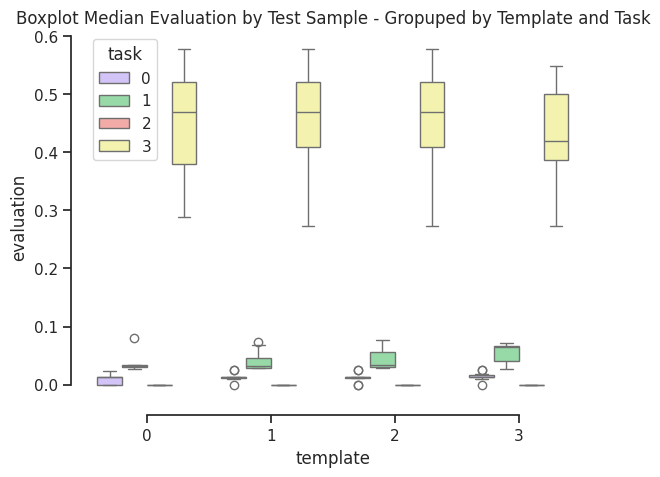

In [16]:
sns.set_theme(style="ticks", palette="pastel")


_plot1 = (
    results
    .select(["template", "task", "test_idx", "evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["m", "g", "r", "y"],
            data=_plot1).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Task')
sns.despine(offset=10, trim=True)

/tmp/ipykernel_3379298/446323439.py:9: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x="template", y="evaluation",


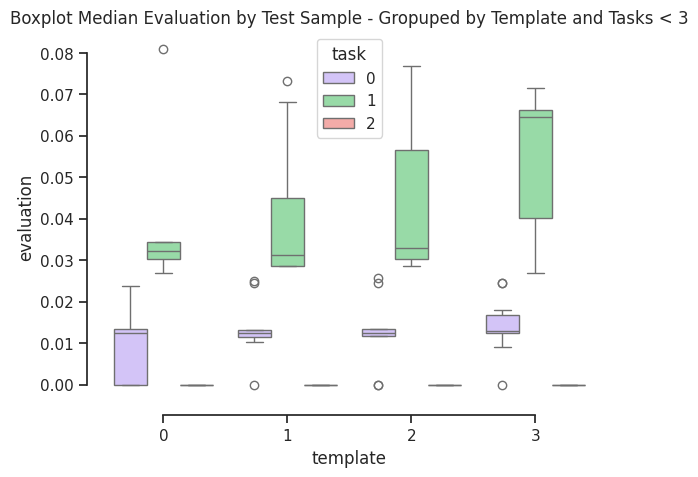

In [17]:
_plot1_2 = (
    results
    .select(["template", "task", "test_idx", "evaluation"])
    .filter(pl.col("task") != 3)
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["m", "g", "r", "y"],
            data=_plot1_2).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')
sns.despine(offset=10, trim=True)

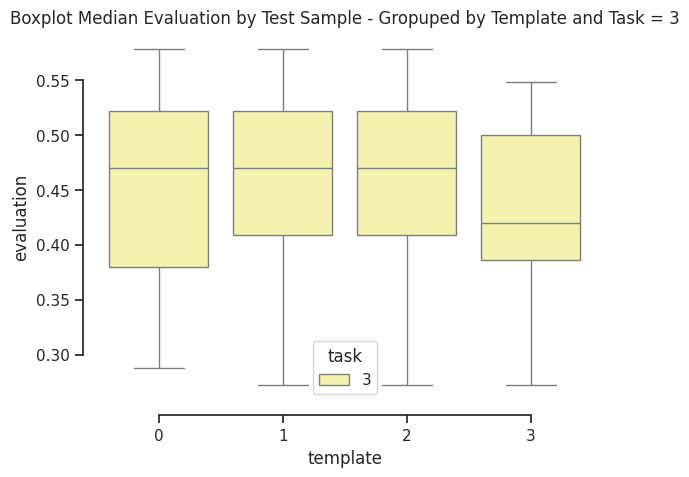

In [23]:
_plot1_3 = (
    results
    .select(["template", "task", "test_idx", "evaluation"])
    .filter(pl.col("task") == 3)
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=[ "y"],
            data=_plot1_3).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Task = 3')
sns.despine(offset=10, trim=True)

## General Performance by Instruction, Task and Proportion

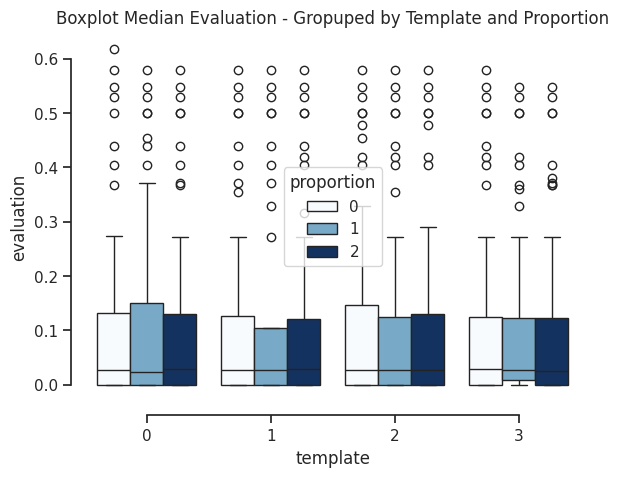

In [29]:
sns.set_theme(style="ticks", palette="pastel")


_plot2 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette="Blues",
            data=_plot2).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion')
sns.despine(offset=10, trim=True)